### Exercise 1

Often it is easier to train NNs on features of the data series than the raw time data itself, which is where Fourier Transform comes into play. Fourier Transform allows us to split the raw data into its principle signals, from there we can filter out the unwated signals if we want such as noise, seasonality, etc. After cleaning, feeding the features (the sinusoidal signals produced from the FT) into NNs will allow for much faster results and clearer too since we have cleaned the data.

Fourier Transform has been studied for centuries. It is highly optimized, represented clearly in mathematical notation which means the results it produces are clear and free of noise; it is also highly applicable accross a very large amount of fields. Considering the scale of data involved in Fourier Transform, training NNs on such a scale that is free of noise (highly unlikely) and be  as widely applicable as the current FT we have is quite frankly pointless.

### Exercise 2

In essence, the darker parts (less activity in a certain frequency) of the original spectrogram is much more emphisized in the reduced audio's spectrogram, as in the frequencies local to those inactive regions will also have their activity reduced.

One interesting observation is that in the AirportAnnouncement_11 audio, there isn't much activity in the first 0.05 seconds (Significantly more darker region than light), the noise reduction makes it so that there is no activity at all in the reduced audio, which is why it comes up as white in the spectrogram.

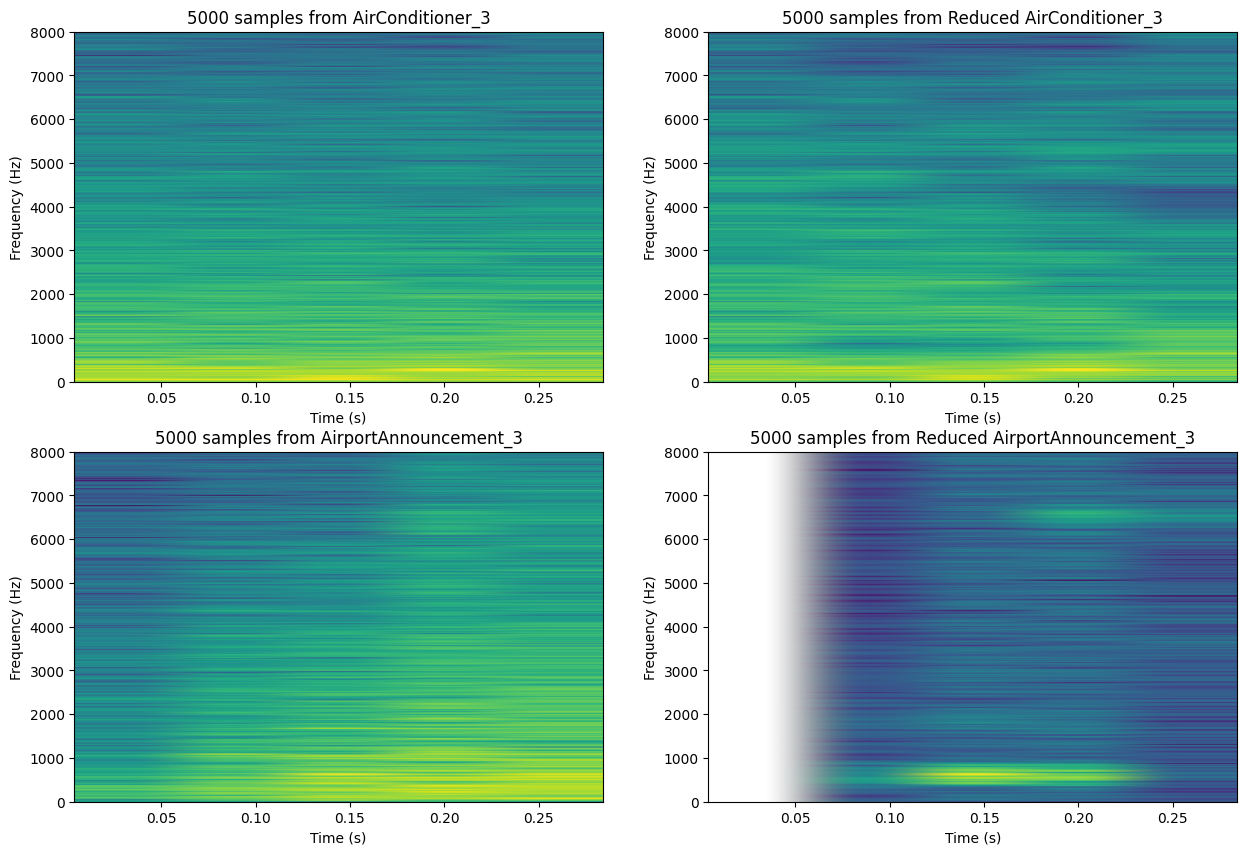

In [48]:
import matplotlib.pyplot as plt

import scipy.io.wavfile as wav
import noisereduce as nr


Fs1, data1 = wav.read('AirConditioner_3.wav')



data1 = data1 / 32767 # 2**15 - 1
#to get the data between -1...1

NFFT=1024 #window size
noverlap=128 #overlapping between windows
mode='psd'
scale='dB'



fig, sub = plt.subplots(2, 2)
sub = sub.flatten()

fig.set_figheight(10)
fig.set_figwidth(15)

ax1 = sub[0]
ax2 = sub[1]
ax3 = sub[2]
ax4 = sub[3]

Pxx, freqs, bins, im = ax1.specgram(data1[:5000], NFFT=NFFT, Fs=Fs1, noverlap=noverlap, mode=mode, scale=scale)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Frequency (Hz)')
ax1.set_title('5000 samples from AirConditioner_3')


reduced_noise = nr.reduce_noise(y=data1, sr=Fs1)
wav.write("AC3.wav", Fs1, reduced_noise)

Fs2,data2 = wav.read("AC3.wav")

Pxx, freqs, bins, im = ax2.specgram(data2[:5000], NFFT=NFFT, Fs=Fs2, noverlap=noverlap, mode=mode, scale=scale)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Frequency (Hz)')
ax2.set_title('5000 samples from Reduced AirConditioner_3')


Fs3,data3 = wav.read("AirportAnnouncement_11.wav")
reduced_noise = nr.reduce_noise(y=data3, sr=Fs3)
wav.write("AA11.wav", Fs3, reduced_noise)

Fs4,data4 = wav.read("AA11.wav")

Pxx, freqs, bins, im = ax3.specgram(data3[:5000], NFFT=NFFT, Fs=Fs3, noverlap=noverlap, mode=mode, scale=scale)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Frequency (Hz)')
ax3.set_title('5000 samples from AirportAnnouncement_3')

Pxx, freqs, bins, im = ax4.specgram(data4[:5000], NFFT=NFFT, Fs=Fs4, noverlap=noverlap, mode=mode, scale=scale)
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Frequency (Hz)')
ax4.set_title('5000 samples from Reduced AirportAnnouncement_3')

plt.show()

### Exercise 3

Normalizing the data produces more accurate results from the NN (10% difference).

The effect can be seen clearly on the confusion matrices as the second confusion matrix has more dark cells than the first in the diagonal (correctly guessed). With that said, the first NN has one class with no wrong guess while the second one has no class all guessed correctly.

The results are labels so they are not scalable like inputs are so output Y is usually left as is.

In [9]:
from aeon.datasets import load_classification
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler


scale = StandardScaler()

# load data
X_train, trainy = load_classification("BasicMotions", split="train")
X_test, testy = load_classification("BasicMotions", split="test")

#Reduce dimension
trainX = X_train.reshape(X_train.shape[0], -1)
testX = X_test.reshape(X_test.shape[0], -1)

# Normalize
normalization=1 
if normalization==1:
    trainX_normalized = scale.fit_transform(trainX)
else:
    trainX_normalized=X_train.to_numpy()


In [14]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from sklearn.preprocessing import LabelEncoder

# convert string class labels to integers and save mapping
le = LabelEncoder()
trainy_num = le.fit_transform(trainy)   # fit on train labels
testy_num = le.transform(testy)         # transform test labels
classes = le.classes_     

inputx = torch.tensor(trainX).float()   
outputy = torch.tensor(trainy_num).long()
inputx_normalized = torch.tensor(trainX_normalized).float() 


'''
Train on unnormalized data first
'''
train_data = data_utils.TensorDataset(inputx, outputy)
train_loader = data_utils.DataLoader(dataset=train_data, batch_size=5, shuffle=True)



In [ ]:

#Start defining classifier network


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class classifier_selfmade_network(nn.Module):
    def __init__(
            self,
            inp_units=3*69, #heart rate, speed and altitude data
            num_units=700,   #hidden units
            num_units1=1000,   #hidden units
            out_units=3,    #classification 0, 1 or 2
            nonlin=F.relu,  #this is the activation function that restrict the 
                               #output values of the each neuron in the layer
            nonlin1=F.relu,  #this is the activation function that restrict the 
                               #output values of the each neuron in the layer
            nonlin2=F.relu,  #this is the activation function that restrict the 
                               #output values of the each neuron in the layer
    ):
        super(classifier_selfmade_network, self).__init__()
        #introducing the variables to 'self' structure
        self.num_units = num_units
        self.num_units1 = num_units1
        self.nonlin = nonlin
        self.nonlin1 = nonlin1
        self.nonlin2 = nonlin2
        # the next shows how the data is flowing through the layers
        self.dense0 = nn.Linear(inp_units, num_units)
        self.dense1 = nn.Linear(num_units, num_units)    
        self.dense2 = nn.Linear(num_units, num_units1)    
        self.output = nn.Linear(num_units1, out_units)

    def forward(self, X, **kwargs):         #forward flow
        X = self.nonlin(self.dense0(X))
        X = self.nonlin1(self.dense1(X))
        X = self.nonlin2(self.dense2(X))
        X = self.output(X)
        return X

#assign our network to simpler name for future use   
net=classifier_selfmade_network()

#ensure network input size matches data
net = classifier_selfmade_network(inp_units=inputx.shape[1], num_units=700, num_units1=1000, out_units=len(classes))
net = nn.DataParallel(net).to(device)

#move the network to dedicated device(s)
net.to(device)

#define network basic optimization parameters
import torch.optim as optim

#ADAM (adaptive estimates of lower-order moments) is very good gradient finding algorithm
optimizer=optim.Adam(net.parameters(),lr=0.00125)  #lr=initial learning rate
 
#criterion=nn.MSELoss(reduction='sum') #for regression/prdiction
criterion = nn.CrossEntropyLoss()      # for classification

#scheduler reduces learning rate in places where are no significant gradient sloes in error surface
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.9, patience=10)


#let us train the network
for epoch in range(120):
    #logs = {}
    train_loss = 0.0
    # supress Learning Rate after the first epoch
    if epoch>0:
        scheduler.step(loss)
    #go the data trough by the baches
    for (xd,yd) in train_loader:
        yd = yd.type(torch.LongTensor) #for classification problems

        #load the data to the device one batch at a time (input+output)       
        xd = xd.to(device)
        yd = yd.to(device)
        
        #Get predictions from the input values (batch at a time)
        outputti = net(xd)
        #zero the parameter gradients
        optimizer.zero_grad()

        # Calculate Loss:  
        loss = criterion(outputti, yd)
        # Fed the error backwards to the network (learning from mistakes!)
        loss.backward()
        # Updating parameters
        optimizer.step()
        # Collect error for the user
        train_loss += loss.item()

    # Print Learning Rate and temoral epoch error = loss 
    print("Epoch:",epoch, "\tLR:",optimizer.param_groups[0]['lr'],"\tTraining Loss: ", (train_loss / len(train_loader)))   


UNORMALIZED data NN accuracy 60.0 %


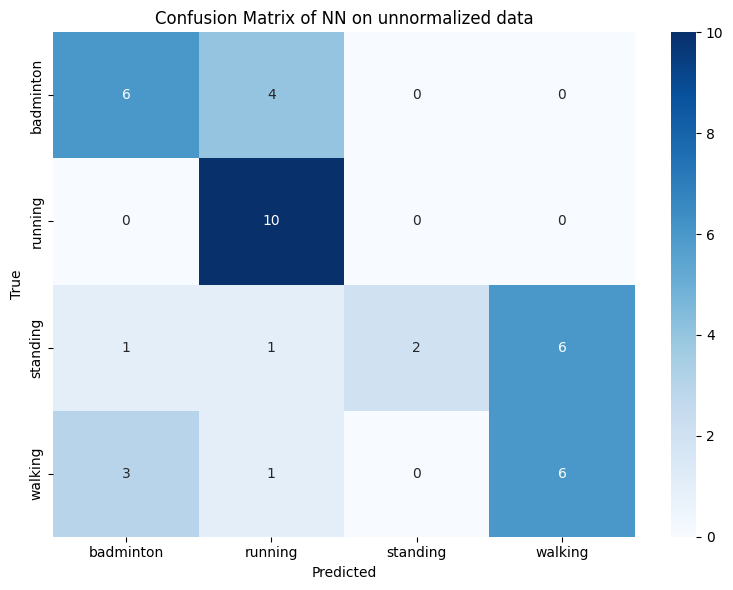

In [41]:
#Test new NN

testx = torch.tensor(testX.reshape(testX.shape[0], -1)).float()
testy_tensor = torch.tensor(testy_num).long()

input_tensor=testx.to(device)
test_values=net(input_tensor)

test_values=net(input_tensor)
test_values=test_values.detach().cpu().numpy()

preds = np.argmax(test_values, axis=1)
gt = testy_tensor.cpu().numpy() if hasattr(testy_tensor, "cpu") else np.array(testy_tensor)

correct=0 
total=len(test_values) 


for i in range(0,len(test_values)):
     predicted = np.argmax(test_values[i])
     #print(y_test[i], predicted, test_values[i])
     correct += (predicted == testy_tensor[i]).item()


print("UNORMALIZED data NN accuracy",correct/total*100, "%")


cm = confusion_matrix(gt, preds)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix of NN on unnormalized data")
plt.tight_layout()
plt.show()



In [ ]:
#Now we test with NORMALIZED DATA

train_data = data_utils.TensorDataset(inputx_normalized, outputy)
train_loader = data_utils.DataLoader(dataset=train_data, batch_size=5, shuffle=True)
for epoch in range(120):
    #logs = {}
    train_loss = 0.0
    # supress Learning Rate after the first epoch
    if epoch>0:
        scheduler.step(loss)
    #go the data trough by the baches
    for (xd,yd) in train_loader:
        yd = yd.type(torch.LongTensor) #for classification problems

        #load the data to the device one batch at a time (input+output)       
        xd = xd.to(device)
        yd = yd.to(device)
        
        #Get predictions from the input values (batch at a time)
        outputti = net(xd)
        #zero the parameter gradients
        optimizer.zero_grad()

        # Calculate Loss:  
        loss = criterion(outputti, yd)
        # Fed the error backwards to the network (learning from mistakes!)
        loss.backward()
        # Updating parameters
        optimizer.step()
        # Collect error for the user
        train_loss += loss.item()

    # Print Learning Rate and temoral epoch error = loss 
    print("Epoch:",epoch, "\tLR:",optimizer.param_groups[0]['lr'],"\tTraining Loss: ", (train_loss / len(train_loader)))   


NORMALIZED data NN accuracy 70.0 %


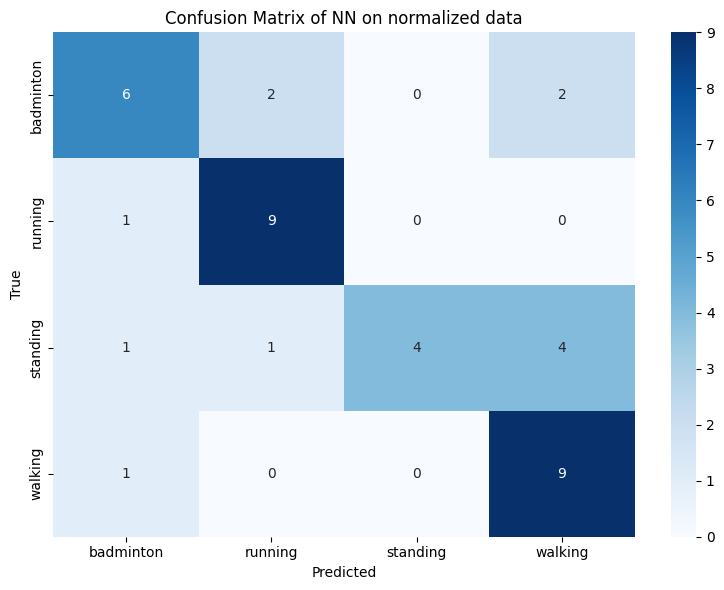

In [39]:
#Test new NN

testx = torch.tensor(testX.reshape(testX.shape[0], -1)).float()
testy_tensor = torch.tensor(testy_num).long()

input_tensor=testx.to(device)
test_values=net(input_tensor)

test_values=net(input_tensor)
test_values=test_values.detach().cpu().numpy()

preds = np.argmax(test_values, axis=1)
gt = testy_tensor.cpu().numpy() if hasattr(testy_tensor, "cpu") else np.array(testy_tensor)

correct=0 
total=len(test_values) 

for i in range(0,len(test_values)):
     predicted = np.argmax(test_values[i])
     #print(y_test[i], predicted, test_values[i])
     correct += (predicted == testy_tensor[i]).item()

print("NORMALIZED data NN accuracy",correct/total*100, "%")

cm = confusion_matrix(gt, preds)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix of NN on normalized data")
plt.tight_layout()
plt.show()